# Consequences of low power

In [1]:
library(foreach)
library(doMC)
registerDoMC(4)
library(ggplot2)
theme_set(theme_bw())
library(repr)
options(repr.plot.width=6, repr.plot.height=4)

Loading required package: iterators
Loading required package: parallel


In [2]:

power.t.test(n = 50, delta = .1, sig.level = .05)


     Two-sample t test power calculation 

              n = 50
          delta = 0.1
             sd = 1
      sig.level = 0.05
          power = 0.0715
    alternative = two.sided

NOTE: n is number in *each* group


In [3]:
do.sim <- function(n, delta) {
    z <- rep(0:1, each = n)
    y <- z * delta + rnorm(n * 2)
    
    r <- t.test(y ~ z)
    data.frame(est = unname(r$estimate[2] - r$estimate[1]), p = r$p.value)
}
do.sim(50, .1)

,est,p
1,-0.000216,0.999


In [4]:
results <- foreach(i = 1:1e4, .combine = rbind) %dopar% do.sim(50, .1)

In [5]:
summary(results)

      est               p        
 Min.   :-0.694   Min.   :0.000  
 1st Qu.:-0.036   1st Qu.:0.199  
 Median : 0.100   Median :0.447  
 Mean   : 0.099   Mean   :0.461  
 3rd Qu.: 0.231   3rd Qu.:0.711  
 Max.   : 0.980   Max.   :1.000  

stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.


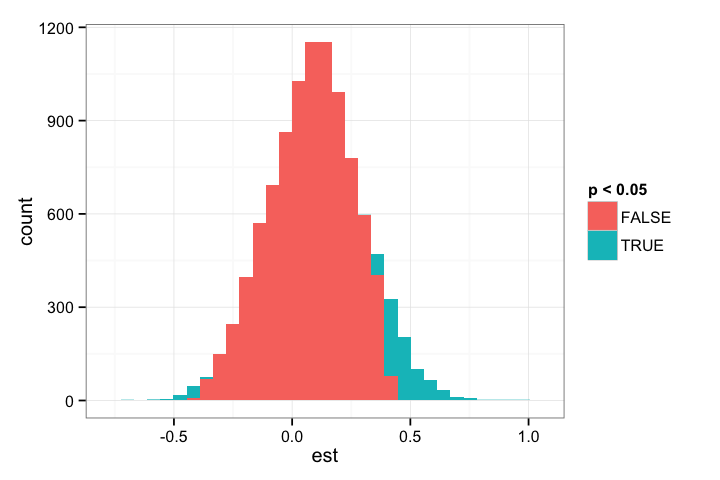

In [6]:
ggplot(
    aes(x = est, fill = p < 0.05),
    data = results
) +
geom_histogram()

## Overestimating effects

In [7]:
summary(results$est)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -0.694  -0.036   0.100   0.099   0.231   0.980 

In [8]:
summary(results$est[results$p < 0.05])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -0.694   0.407   0.452   0.395   0.514   0.980 

Gelman and Carlin call the "exaggeration factor: the expected (absolute) value of the estimate divided by the effect size, if it is statistically significantly different from zero."

In [9]:
mean(abs(results$est[results$p < 0.05]))

[1] 0.477

In [10]:
mean(abs(results$est[results$p < 0.05])) / .1

[1] 4.77

That is, we get estimates that are almost 5 times too large.

We also get estimates with the wrong sign.

In [11]:
table(sign(results$est[results$p < 0.05]))


 -1   1 
 75 740 

In [12]:
mean(results$est[results$p < 0.05] < 0)

[1] 0.092

This isn't the worst possible case. Many experiments have even lower power.

### In combination with bad stopping rules

Low power also makes the use of stopping rules more problematic.

Here we do a simulation where we start with some n in each of treatment and control. Then check whether we have a significant result. If not, add some incremental n to each condition. Repeat until there is a significant result or we hit a maximum n.

In [13]:
add.data <- function(n, d, z = c(), y = c()) {
    z.new <- rep(0:1, each = n)
    y.new <- z.new * d + rnorm(n * 2)
    z <- c(z, z.new)
    y <- c(y, y.new)
    t <- t.test(y ~ z)
    list(z = z, y = y, t = t)
}

do.stopping.rule.sim <- function(n, d, n.inc, n.max) {
    r <- list(z = c(), y = c())
    while (TRUE) {
        nc <- length(r$z) / 2
        if (nc + n.inc >= n.max)
            break;
        ni <- if(nc == 0) n else n.inc
        r <- add.data(ni, d, r$z, r$y)
        if (r$t$p.value < 0.05)
            break;
    }
    r
}

In [14]:
# one run, with no true effect
do.stopping.rule.sim(n = 20, d = 0, n.inc = 2, n.max = 120)$t


	Welch Two Sample t-test

data:  y by z
t = -0.7, df = 200, p-value = 0.5
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.361  0.172
sample estimates:
mean in group 0 mean in group 1 
        -0.0166          0.0780 


Run many simulations of experiments run with this stopping rule:

In [18]:
set.seed(8001)
sr <- foreach(i = 1:1e3, .combine = rbind) %dopar% {
    r <- do.stopping.rule.sim(20, 0, 5, 50)
    data.frame(est = r$t$estimate[2] - r$t$estimate[1],
               p = r$t$p.value,
               n = length(r$z)
              )
    }

In [19]:
summary(sr)

      est               p               n       
 Min.   :-1.073   Min.   :0.000   Min.   :40.0  
 1st Qu.:-0.154   1st Qu.:0.216   1st Qu.:90.0  
 Median :-0.022   Median :0.506   Median :90.0  
 Mean   :-0.015   Mean   :0.486   Mean   :85.7  
 3rd Qu.: 0.128   3rd Qu.:0.751   3rd Qu.:90.0  
 Max.   : 1.003   Max.   :0.998   Max.   :90.0  

In [20]:
mean(sr$p < 0.05)

[1] 0.13

That is, rather than Type I error rate of 5%, we have 13%.